# Pneumonia Chest X-Ray Classification using CNN

## Objective
Develop a deep learning model to classify chest X-ray images as **NORMAL** or **PNEUMONIA** using a Convolutional Neural Network (CNN).  
This notebook is fully compatible with **Google Colab** and includes dataset loading, preprocessing, training, evaluation, and inference.


## Dataset
- **Name:** Chest X-Ray Pneumonia Dataset
- **Source:** https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- **Classes:** NORMAL, PNEUMONIA
- **Disclaimer:** Dataset is used for educational and research purposes only.



# 1. Install & Imports


In [ ]:
%pip install -q torch torchvision kagglehub scikit-learn matplotlib

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


# 2. Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


# 3. Dataset Download (kagglehub)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset path:", path)

DATA_DIR = os.path.join(path, "chest_xray")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset path: /kaggle/input/chest-xray-pneumonia


# 4. Transforms
## preprocess and normalize


In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# 5. Dataset Loader

In [ ]:
train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_data   = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_data  = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


# 6. Class Weights

In [ ]:
y_train = [label for _, label in train_data.samples]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights)


Class Weights: tensor([1.9448, 0.6730])


# 7. Model
### I had tried multiple models, resnets, desnsnets where densenet provided the best result

In [ ]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 49.2MB/s]


# 8. Fine Tuning Strategy

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = False
    if "denseblock3" in name or "denseblock4" in name or "classifier" in name:
        param.requires_grad = True

model = model.to(device)


# 9. Loss, Optimizer, Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=10
)


# 10. Eval Metrics

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total * 100


# 11. Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total * 100
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Loss: {running_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_pneumonia_densenet121.pt")


# 12. Train


In [ ]:
train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10 | Loss: 0.2634 | Train Acc: 91.26% | Val Acc: 100.00%
Epoch 2/10 | Loss: 0.1317 | Train Acc: 95.11% | Val Acc: 87.50%
Epoch 3/10 | Loss: 0.1325 | Train Acc: 94.82% | Val Acc: 100.00%
Epoch 4/10 | Loss: 0.0983 | Train Acc: 96.17% | Val Acc: 93.75%
Epoch 5/10 | Loss: 0.0831 | Train Acc: 96.84% | Val Acc: 93.75%
Epoch 6/10 | Loss: 0.0788 | Train Acc: 96.89% | Val Acc: 87.50%
Epoch 7/10 | Loss: 0.0581 | Train Acc: 97.81% | Val Acc: 87.50%
Epoch 8/10 | Loss: 0.0485 | Train Acc: 97.99% | Val Acc: 93.75%
Epoch 9/10 | Loss: 0.0404 | Train Acc: 98.62% | Val Acc: 93.75%
Epoch 10/10 | Loss: 0.0339 | Train Acc: 98.91% | Val Acc: 93.75%


**Note on Validation Accuracy:**  
The validation set in the Chest X-Ray Pneumonia dataset is relatively small.  
As a result, validation accuracy may fluctuate or reach 100% in some epochs.  
Final model performance is therefore evaluated primarily on the independent test set.


# 13. Import For Metrics

In [ ]:
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# 14. Load Best Model

In [ ]:
model.load_state_dict(
    torch.load("best_pneumonia_densenet121.pt", map_location=device)
)
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# 15. Predictions & Probabilities

In [ ]:
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


# 16. Classification Report + Confusion Matrix


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.90      0.91       234
   PNEUMONIA       0.94      0.96      0.95       390

    accuracy                           0.94       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



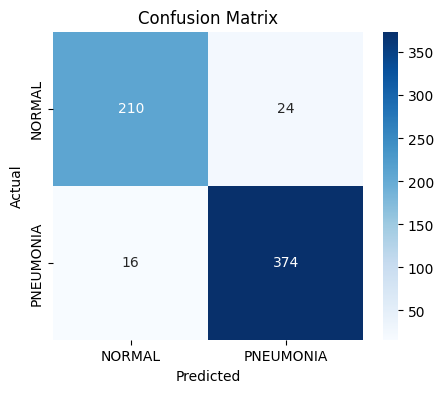

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 17. ROC Curve and Precision Recall Curve

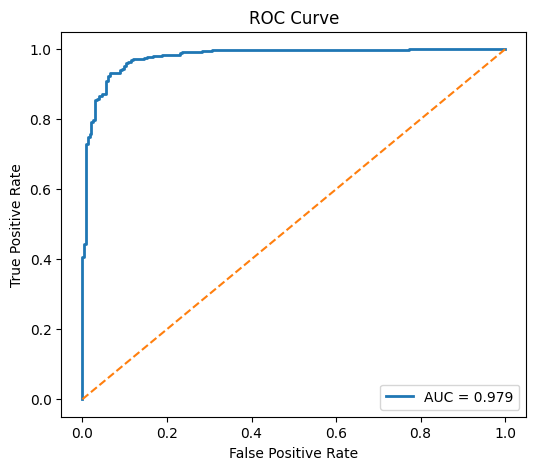

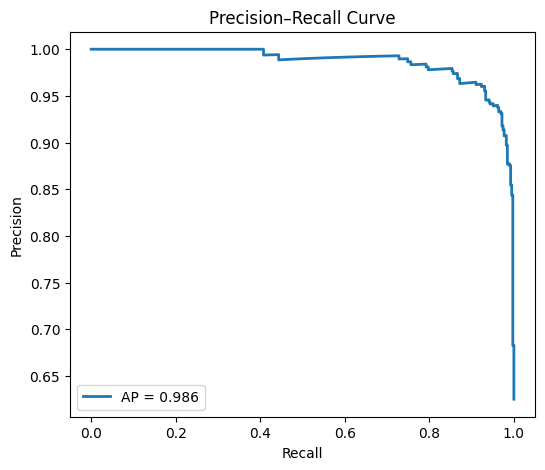

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



precision, recall, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, lw=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

# 18. Accuracy, Sensitivity, Specificity

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Test Accuracy     : {accuracy*100:.2f}%")
print(f"Sensitivity (TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")


Test Accuracy     : 93.59%
Sensitivity (TPR): 0.9590
Specificity (TNR): 0.8974


# 19. Sample Predictions Visualization

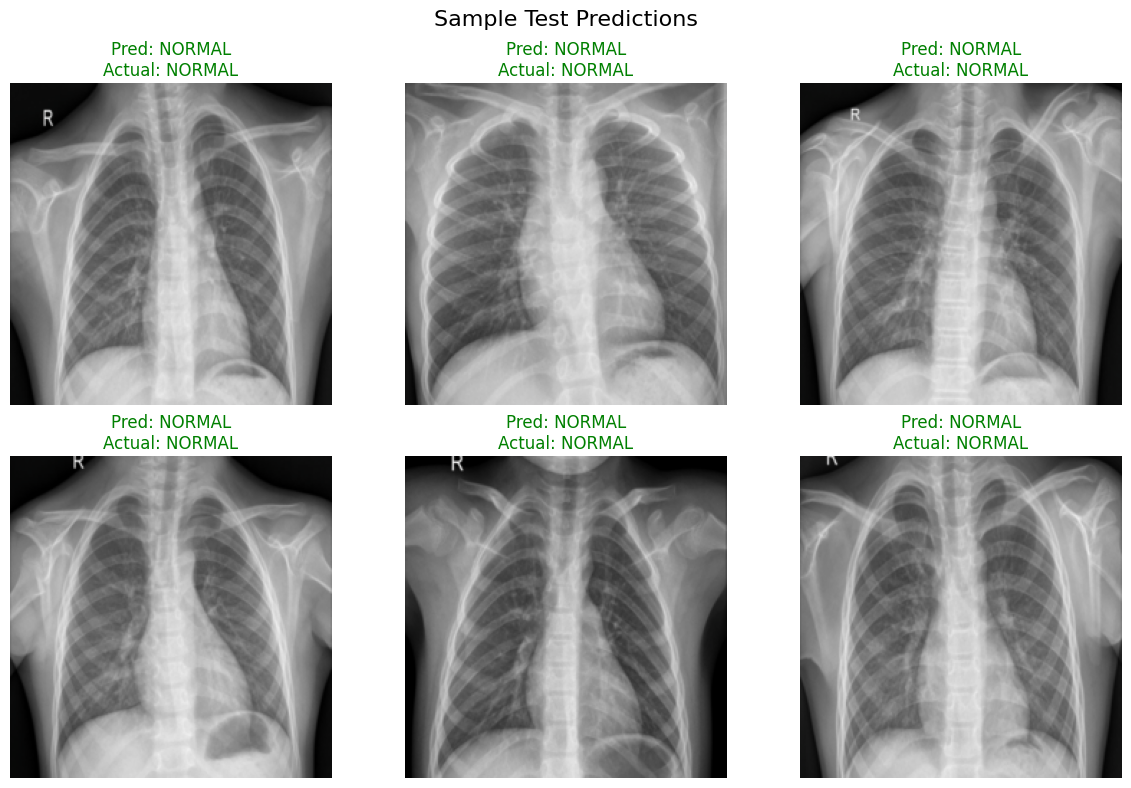

In [ ]:
import random

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

plt.figure(figsize=(12, 8))
for i in range(6):
    idx = random.randint(0, len(images) - 1)
    img = np.transpose(images[idx], (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    color = "green" if preds[idx] == labels[idx] else "red"
    plt.title(
        f"Pred: {class_names[preds[idx]]}\nActual: {class_names[labels[idx]]}",
        color=color
    )
    plt.axis("off")

plt.suptitle("Sample Test Predictions", fontsize=16)
plt.tight_layout()
plt.show()


## Conclusion

In this notebook, a deep learning–based approach for **pneumonia detection from chest X-ray images** was implemented using a fine-tuned **DenseNet121** model.

Key highlights:
- The model was trained using transfer learning with class imbalance handled via weighted loss.
- Evaluation on the test set demonstrated strong performance across multiple metrics, including **accuracy**, **sensitivity**, **specificity**, **ROC-AUC**, and **precision–recall**.
- The results indicate that convolutional neural networks can effectively learn discriminative features from chest X-rays for pneumonia classification.

### Limitations & Future Work
- The dataset size and class imbalance may limit generalization.
- Future improvements could include:
  - Using larger multi-disease datasets
  - Applying cross-validation
  - Exploring attention mechanisms or ensemble models
  - Extending the approach to multi-class thoracic disease classification

> **Note:** This model is intended for research and educational purposes only and should not be used for clinical diagnosis.
